# Implementation of XLM-Roberta and DistilBert Transformer models for classification of Multilinguistic Toxic Comments

# Model-1 XLM-Roberta Model

**Importing required Libraries**

In [1]:
!pip install --upgrade pip
!pip install -q textstat

     |████████████████████████████████| 1.5 MB 3.0 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.1.1
    Uninstalling pip-20.1.1:
      Successfully uninstalled pip-20.1.1


In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import gc
import os
import time
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
from transformers import *
from sklearn.metrics import *
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F



import warnings
warnings.filterwarnings("ignore")

import os
import gc
import re
import folium
import textstat
from scipy import stats
from colorama import Fore, Back, Style, init

import math
import numpy as np
import scipy as sp
import pandas as pd

import random
import networkx as nx
from pandas import Timestamp

from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot

import requests
from IPython.display import HTML

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt

tqdm.pandas()

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import transformers
import tensorflow as tf

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.optimizers import Adam
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import LSTM, GRU, Conv1D, SpatialDropout1D

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.constraints import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *

from sklearn import metrics
from sklearn.utils import shuffle
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer,\
                                            CountVectorizer,\
                                            HashingVectorizer

from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer  

import nltk
from textblob import TextBlob

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer

stopword=set(STOPWORDS)

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

np.random.seed(0)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


**Setup TPU configuration**

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)
print(strategy.num_replicas_in_sync)

BATCH_SIZE = 16 * strategy.num_replicas_in_sync

8


**Importing required datasets from .CSV files**

In [4]:
train1 = pd.read_csv("../input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")


train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

train3 = pd.read_csv('../input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-es-cleaned.csv')


valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')


toxic = len(train2[['comment_text', 'toxic']].query('toxic==1'))
# Combine train1 with a subset of train2
train_cat = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    
    train3[['comment_text', 'toxic']].query('toxic==0'),
    train3[['comment_text', 'toxic']].query('toxic==1'),   
  
]).sample(n=500000).reset_index(drop=True) #restricting data to 500,000 records due to memory issue

test_data = test
train_data = train_cat

maxlen = 192

In [5]:
print(len(train_data))
train_data.head()

500000


,comment_text,toxic
0,"""\n\nVandalismo\nEsta edición constituye vanda...",0
1,"De acuerdo, Doug, lo he llevado a WP: RSN segú...",0
2,Usted (nuevamente) ha estado modificando las c...,0
3,"Smh....15, age you are eligible to undergo a t...",1
4,Why on Earth is a post mentioning fraud commit...,1


In [6]:
valid.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


# Data Preprocessing

**Clean the text (remove usernames and links)**

In [7]:
val = valid
train = train_data

def clean(text):
    text = text.fillna("fillna").str.lower()
    text = text.map(lambda x: re.sub('\\n',' ',str(x)))
    text = text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    text = text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    text = text.map(lambda x: re.sub("\(http://.*?\s\(http://.*\)",'',str(x)))
    return text

val["comment_text"] = clean(val["comment_text"])
test_data["content"] = clean(test_data["content"])
train["comment_text"] = clean(train["comment_text"])

# More Text Cleaning

Applying text cleaning techniques like clean_text,replace_typical_misspell,handle_contractions,fix_quote on train,test and validation set

In [8]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\xa0', '\t',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']

mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"couldnt" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"doesnt" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"havent" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"shouldnt" : "should not",
"that's" : "that is",
"thats" : "that is",
"there's" : "there is",
"theres" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"theyre":  "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}


def clean_text(x):
    x = str(x).replace('\n','')
    for punct in puncts:
        x = x.replace(punct, '')
    return x

def clean_numbers(x):
   result = ''.join([i for i in x if not i.isdigit()])
   return result




In [9]:
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

def handle_contractions(x):
    x = tokenizer.tokenize(x)
    return x

def fix_quote(x):
    x = [x_[1:] if x_.startswith("'") else x_ for x_ in x]
    x = ' '.join(x)
    return x

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


def replace_typical_misspell(text):
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)


def clean_data(df, columns: list):
    for col in columns:
        df[col] = df[col].apply(lambda x: clean_numbers(x))
        df[col] = df[col].apply(lambda x: clean_text(x.lower())) 
        df[col] = df[col].apply(lambda x: replace_typical_misspell(x))
        df[col] = df[col].apply(lambda x: handle_contractions(x))  
        df[col] = df[col].apply(lambda x: fix_quote(x))   
    
    return df

In [10]:
%%time
input_columns = [
    'comment_text'   
]

'''applying text cleaning techniques like clean_text,replace_typical_misspell,handle_contractions,fix_quote 
on train,test and validation set'''

train = clean_data(train, input_columns ) 
val = clean_data(val, input_columns )

CPU times: user 6min 21s, sys: 2.76 s, total: 6min 24s
Wall time: 6min 25s


In [11]:
train_data.head(20)

,comment_text,toxic
0,vandalismo esta edición constituye vandalismo ...,0
1,de acuerdo doug lo he llevado a wp rsn según s...,0
2,usted nuevamente ha estado modificando las cif...,0
3,smh age you are eligible to undergo a transgen...,1
4,why on earth is a post mentioning fraud commit...,1
5,i think that is actually useful information th...,0
6,ok thanks ill be looking for that just in case...,0
7,outsider once again we agree it seems that thi...,1
8,y qu todo esto significa que tiene un techo ba...,0
9,lol referring to your comment if youre just a ...,0


In [12]:
%%time
input_columns = [
    'content'   
]
test_data = clean_data(test_data, input_columns )

del tokenizer

CPU times: user 48.1 s, sys: 9.85 ms, total: 48.2 s
Wall time: 48.2 s


In [13]:
test_data.head(20)

,id,content,lang
0,0,doctor who adlı viki başlığına doctor olarak b...,tr
1,1,вполне возможно но я пока не вижу необходимост...,ru
2,2,quindi tu sei uno di quelli conservativi che p...,it
3,3,malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,resimseldabagcanjpg resminde kaynak sorunu res...,tr
5,5,le truc le plus important dans ta tirade c est...,fr
6,6,px caro editor encontramos problemas na edição...,pt
7,7,el skate es unos de los deportes favoritos de ...,es
8,8,me doy la bienvenida a este usuari le gusta co...,es
9,9,es notablemente tendencioso no se habla de cua...,es


**Roc-Auc Evaluation metric**

In [14]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

        
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

**Tokenization of comments**

In [15]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

**Loading XLM-Roberta model tokenizer**

In [16]:
MODEL = 'jplu/tf-xlm-roberta-large'
# First load the real tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

save_path = '/kaggle/working/xlmr_large/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

('/kaggle/working/xlmr_large/sentencepiece.bpe.model',
 '/kaggle/working/xlmr_large/special_tokens_map.json',
 '/kaggle/working/xlmr_large/added_tokens.json')

**Encoding train, validation and test data**

In [17]:
%%time
x_train = regular_encode(train.comment_text.astype(str), 
                      tokenizer, maxlen=maxlen)
x_valid = regular_encode(val.comment_text.astype(str).values, 
                      tokenizer, maxlen=maxlen)
x_test = regular_encode(test_data.content.astype(str).values, 
                     tokenizer, maxlen=maxlen)

y_valid = val.toxic.values
y_train = train.toxic.values

CPU times: user 6min 2s, sys: 3.26 s, total: 6min 6s
Wall time: 6min 6s


In [18]:
x_train

array([[    0,   131,  2465, ...,     1,     1,     1],
       [    0,     8, 27219, ...,     1,     1,     1],
       [    0, 52364, 22334, ...,     1,     1,     1],
       ...,
       [    0,   173,    31, ...,     1,     1,     1],
       [    0,  3514,    53, ...,     1,     1,     1],
       [    0, 14701,   525, ...,     1,     1,     1]])

In [19]:
x_valid

array([[    0,   473, 54367, ...,     1,     1,     1],
       [    0,   211, 52645, ...,     1,     1,     1],
       [    0, 17159, 17646, ...,     1,     1,     1],
       ...,
       [    0,    36,  4689, ...,     1,     1,     1],
       [    0,    88, 18587, ...,     1,     1,     1],
       [    0, 44563,   266, ...,     1,     1,     1]])

In [20]:
x_test

array([[     0,  22072,   2750, ...,      1,      1,      1],
       [     0,  49637,  23334, ...,      1,      1,      1],
       [     0,  14410,    370, ...,      1,      1,      1],
       ...,
       [     0,   2083,     76, ...,      1,      1,      1],
       [     0,  32699, 130611, ...,      1,      1,      1],
       [     0,    120,      6, ...,      1,      1,      1]])

Training the data with train,validation and test dataset

In [21]:
%%time
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

CPU times: user 665 ms, sys: 2.38 s, total: 3.04 s
Wall time: 4.16 s


# Focal Loss

In [22]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

# Building the model and summary check

In [23]:
def build_model(transformer, loss='binary_crossentropy', max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=3e-5), loss=loss, metrics=[tf.keras.metrics.AUC()])
    
    return model

In [24]:
%%time
with strategy.scope():
    transformer_layer = transformers.TFXLMRobertaModel.from_pretrained(MODEL)
    model = build_model(transformer_layer,loss='binary_crossentropy', max_len=maxlen)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tfxlm_roberta_model (TFXLMRo ((None, 192, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 559,891,457
Trainable params: 559,891,457
Non-trainable params: 0
_________________________________________________________________
CPU times: user 2min 11s, sys: 43.6 s, total: 2min 54s
Wall time: 3min 32s


**Define Define ReduceLROnPlateau callback**

In [25]:

def callback():
    cb = []

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.3, patience=2, 
                                    verbose=1, mode='auto', 
                                    epsilon=0.0001, cooldown=1, min_lr=0.000001)
    cb.append(reduceLROnPlat)
    log = CSVLogger('log.csv')
    cb.append(log)

    RocAuc = RocAucEvaluation(validation_data=(x_valid, y_valid), interval=1)
    cb.append(RocAuc)
    
    return cb


# Visualization of model architecture

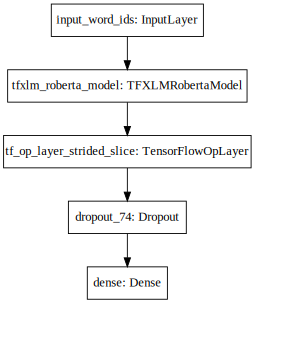

In [26]:
SVG(tf.keras.utils.model_to_dot(model, dpi=80).create(prog='dot', format='svg'))

# Learning rate schedule

In [27]:
def build_lrfn(lr_start=0.000001, lr_max=0.000002, 
               lr_min=0.0000001, lr_rampup_epochs=7, 
               lr_sustain_epochs=0, lr_exp_decay=.87):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

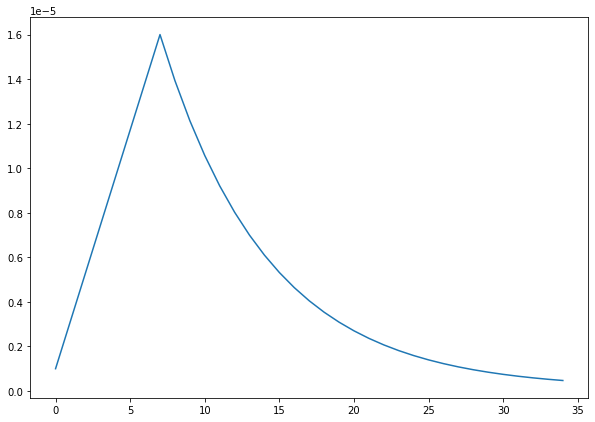

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

lrfn = build_lrfn()
plt.plot([i for i in range(35)], [lrfn(i) for i in range(35)]);

In [29]:
model_path = 'jigsawMultilingual.hdf5'
model_path1 = '/kaggle/working/jigsawMultilingual.hdf5'

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', mode='max', save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=2, 
                   restore_best_weights=True, verbose=1)
lr_callback = LearningRateScheduler(lrfn, verbose=1)

callback_list = [checkpoint,  lr_callback]

# Training

Fitting the model with 3 epochs run due to limited availablity of Ram memory

In [31]:
%%time
N_STEPS = x_train.shape[0] // BATCH_SIZE
EPOCHS = 3
train_history = model.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    validation_data=valid_dataset,
    callbacks=callback_list,
    epochs=EPOCHS
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/3
3906/3906 [==============================] - 1726s 442ms/step - loss: 0.2599 - auc: 0.9479 - val_loss: 0.2974 - val_auc: 0.9076 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 3.142857142857143e-06.
Epoch 2/3
3906/3906 [==============================] - 1657s 424ms/step - loss: 0.1327 - auc: 0.9859 - val_loss: 0.3238 - val_auc: 0.9043 - lr: 3.1429e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 5.285714285714285e-06.
Epoch 3/3
3906/3906 [==============================] - 1659s 425ms/step - loss: 0.1078 - auc: 0.9906 - val_loss: 0.3516 - val_auc: 0.8899 - lr: 5.2857e-06
CPU times: user 8min 10s, sys: 25.4 s, total: 8min 35s
Wall time: 1h 27min 20s


In [32]:
train_history_df1 = pd.DataFrame.from_dict(train_history.history)
train_history_df1

,loss,auc,val_loss,val_auc,lr
0,0.259894,0.947915,0.297423,0.907574,1.000000e-06
1,0.132681,0.985946,0.323793,0.904346,3.142857e-06
2,0.107759,0.990583,0.351620,0.889877,5.285714e-06


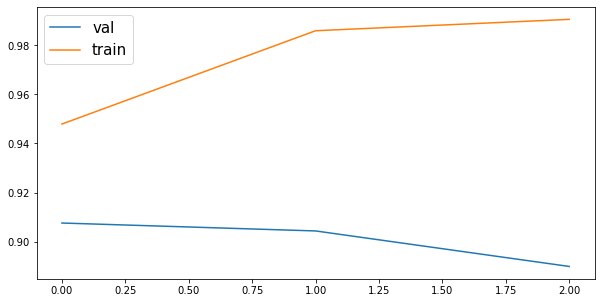

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_history_df1['val_auc'], label='val')
plt.plot(train_history_df1['auc'], label='train')
plt.legend(fontsize=15)

In [34]:
if os.path.exists(model_path1):
    model.load_weights(model_path1)

**Evaluating the model fit**

In [35]:
score = model.evaluate(x_valid, y_valid, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])   

250/250 [==============================] - 10s 40ms/step - loss: 0.3514 - auc: 0.8896
Test Score: 0.35144925117492676
Test Accuracy: 0.8895758390426636


In [36]:
log_dir = "/kaggle/working/log.csv"
if os.path.exists(log_dir):
    os.remove(log_dir)

# Predicting the toxicity - Output

In [37]:
output = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/' + 'sample_submission.csv')
output['toxic'] = model.predict(test_dataset, verbose=1)
output.to_csv('output_xml.csv', index=False)

499/499 [==============================] - 76s 153ms/step


In [38]:
output

,id,toxic
0,0,0.000025
1,1,0.000007
2,2,0.120784
3,3,0.000010
4,4,0.000016
...,...,...
63807,63807,0.011993
63808,63808,0.000107
63809,63809,0.002484
63810,63810,0.000071


In [39]:
y_pred1 = model.predict(test_dataset, verbose=1)

499/499 [==============================] - 56s 112ms/step


In [40]:
y_pred1

array([[2.5421381e-05],
       [7.0631504e-06],
       [1.2078422e-01],
       ...,
       [2.4839342e-03],
       [7.0750713e-05],
       [5.0365925e-06]], dtype=float32)

In [41]:
import random
spl = random.sample(range(len(y_pred1)), 10)
for text, sentiment in zip(test.content[spl], y_pred1[spl]):
    print(sentiment, text)

[9.119511e-06] obrigado por wikiaprendermãos a obra siga o link vermelho acima com o nome do artigo boas contribuições andrezitos msgmail
[0.6305814] eu tambm já me enganei tanto lixo que deixa a gente tonto luís felipe braga
[0.00070539] sto impazzendo ufficialmente penso che tu abbia visto l inizio di edit war tra sostenitori della o paulox e della a akela ho messo un po di ordine si era creata una doppia discussione e si era persa la cronologia paulox aveva copiaincollato redirect e articolo per invertirli non li aveva spostati correttamente e si era creato il panico nel frattempo ho spostato il tuo intervento in discussionescoutismo di cui ora discussionescautismo redirect e ho meso una nota guarda se sei d accordo ciao e grazie shaka you talkin to me giu cest
[0.2428748] s il le fallait encore voil une dmonstration de votre mauvaise foi abyssale le terme youpin c est si j ose crire la cerise sur le gteau l essentiel ce sont les paroles haineuses du capitaine de gaulle les juifs so

#  DistilBert Model Implementation

Loading the required libraries

In [42]:
import os
import gc
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import glob

In [43]:
import string
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from gensim import utils
import gensim.parsing.preprocessing as gsp

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from tqdm.notebook import tqdm
import tokenizers
from tokenizers import BertWordPieceTokenizer

**Loading the required dataset from .CSV files**

In [44]:
# Loading train data
needed_cols = ['toxic', 'comment_text']

translated_train_files = glob.glob('/kaggle/input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-*-cleaned.csv')
translated_train_dfs = []
for filename in translated_train_files:
    df = pd.read_csv(filename, usecols=needed_cols)
    lang = re.findall('train-google-(.*)-cleaned.csv', filename)[0]
    df['lang'] = lang
    translated_train_dfs.append(df)

train_en = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv", usecols=needed_cols)
train_en['lang'] = 'en'

translated_train_dfs.append(train_en)
    
train_df = pd.concat(translated_train_dfs).sample(n=500000).reset_index(drop=True) #Training dataset

y_train = train_df['toxic'].values


del df, translated_train_dfs, train_en
gc.collect()


48180

In [45]:
print(len(train_df))
train_df.head(10)

500000


,comment_text,toxic,lang
0,"""\n\n Bien sûr, cet utilisateur a un agenda. I...",0,fr
1,"""\n ::::: Yetim bot'un etiketlemesi sonucunda ...",0,tr
2,Lütfen crony saçmalığını durdur. Ben kimseye s...,1,tr
3,It is about the remarkable popularity of the p...,0,en
4,": Obrigado, meu erro.",0,pt
5,", 8 Ağustos 2006 (UTC)\n Bu bağlantıda referan...",0,tr
6,""":: Parece viável. No entanto, acho que a idéi...",0,pt
7,"""\n\nI read the cited reference. It is extreme...",0,en
8,Novembro de 2005 (UTC)\n\nA gordura nunca é co...,0,pt
9,"""\n{| class = """" messagebox conversa-padrão """"...",0,pt


# Data Preprocessing

In [46]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text) # number
    text = re.sub(r'#[\S]+\b', '', text) # hash
    text = re.sub(r'@[\S]+\b', '', text) # mention
    text = re.sub(r'https?\S+', '', text) # link
    text = re.sub(r'\s+', ' ', text) # multiple white spaces
#     text = re.sub(r'\W+', ' ', text) # non-alphanumeric
    return text.strip()

In [47]:
def text_process(text):
    ws = text.split(' ')
    if(len(ws)>160):
        text = ' '.join(ws[:160]) + ' ' + ' '.join(ws[-32:])
    return text


**Loading DistilBert Tokenizer**

In [48]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=False)

**Encoding of comments**

In [49]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
 
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

181

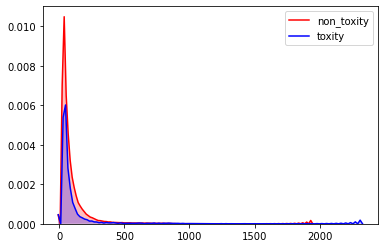

In [50]:
def len_sent(data):
    return len(data.split())
train_df["num_words_comment_text"] = train_df["comment_text"].apply(lambda x : len_sent(x))
sns.kdeplot(train_df[train_df["toxic"] == 0]["num_words_comment_text"].values, shade = True, color = "red", label='non_toxity')
sns.kdeplot(train_df[train_df["toxic"] == 1]["num_words_comment_text"].values, shade = True, color = "blue", label='toxity')

del train_df['toxic']; gc.collect()

**Configuration setup**

In [51]:

AUTO = tf.data.experimental.AUTOTUNE
SHUFFLE = 2048
EPOCHS1 = 20
EPOCHS2 = 4
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192
VERBOSE = 1

**Detect hardware to return appropriate distribution strategy**

In [52]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


Encoding train data

In [53]:
train_df['comment_text'] = train_df['comment_text'].apply(lambda x: clean_text(x))
train_df['comment_text'] = train_df['comment_text'].apply(lambda x: text_process(x))
x_train = fast_encode(train_df['comment_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)

In [54]:
x_train

array([[  101, 27448, 10326, ..., 53388, 16946,   102],
       [  101,   131,   131, ..., 10457, 17145,   102],
       [  101, 23859, 10123, ...,     0,     0,     0],
       ...,
       [  101, 17622, 90139, ...,     0,     0,     0],
       [  101,   113, 11780, ...,     0,     0,     0],
       [  101, 16466, 10228, ...,     0,     0,     0]])

Loading and cleaning validation dataset

In [55]:

valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
valid['comment_text'] = valid.apply(lambda x: clean_text(x['comment_text']), axis=1)
valid['comment_text'] = valid['comment_text'].apply(lambda x: text_process(x))

Encoding validation dataset

In [56]:
x_valid = fast_encode(valid['comment_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
y_valid = valid['toxic'].values

Build dataset objects

In [57]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(SHUFFLE)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

gc.collect()

26

**Call Backs**

In [58]:
lrs = ReduceLROnPlateau(monitor='val_auc', mode ='max', factor = 0.7, min_lr= 1e-7, verbose = 1, patience = 2)
es1 = EarlyStopping(monitor='val_auc', mode='max', verbose = 1, patience = 5, restore_best_weights=True)
es2 = EarlyStopping(monitor='auc', mode='max', verbose = 1, patience = 1, restore_best_weights=True)
callbacks_list1 = [lrs,es1]
callbacks_list2 = [lrs,es2]

**Build model**

In [59]:
def build_model(transformer, max_len=512):

    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.4)(cls_token)
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
    
    return model

**Loading model into TPU**

In [60]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 192, 768),)       134734080 
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 769       
Total params: 134,734,849
Trainable params: 134,734,849
Non-trainable params: 0
_________________________________________________________________
CPU times: user 38.2 s, sys: 15.4 s, total: 53.5 s
Wall time: 56.6 s


**Training the model**

In [61]:
n_steps = len(y_train) // (BATCH_SIZE*8)

train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS1,
    callbacks=callbacks_list1,
    verbose=VERBOSE
)

del train_dataset; gc.collect()

Epoch 1/20
488/488 [==============================] - 72s 147ms/step - loss: 0.2110 - accuracy: 0.9206 - auc: 0.8839 - val_loss: 0.3000 - val_accuracy: 0.8740 - val_auc: 0.8736 - lr: 1.0000e-05
Epoch 2/20
488/488 [==============================] - 54s 110ms/step - loss: 0.1580 - accuracy: 0.9377 - auc: 0.9421 - val_loss: 0.2713 - val_accuracy: 0.8825 - val_auc: 0.8948 - lr: 1.0000e-05
Epoch 3/20
488/488 [==============================] - 53s 109ms/step - loss: 0.1430 - accuracy: 0.9438 - auc: 0.9526 - val_loss: 0.2629 - val_accuracy: 0.8839 - val_auc: 0.9031 - lr: 1.0000e-05
Epoch 4/20
488/488 [==============================] - 53s 110ms/step - loss: 0.1364 - accuracy: 0.9463 - auc: 0.9565 - val_loss: 0.2870 - val_accuracy: 0.8824 - val_auc: 0.9049 - lr: 1.0000e-05
Epoch 5/20
488/488 [==============================] - 54s 110ms/step - loss: 0.1279 - accuracy: 0.9501 - auc: 0.9616 - val_loss: 0.2769 - val_accuracy: 0.8840 - val_auc: 0.9085 - lr: 1.0000e-05
Epoch 6/20
488/488 [==========

70351

In [62]:
train_history_df = pd.DataFrame.from_dict(train_history.history)
train_history_df

,loss,accuracy,auc,val_loss,val_accuracy,val_auc,lr
0,0.211017,0.920626,0.883905,0.299954,0.874000,0.873566,0.000010
1,0.157979,0.937708,0.942069,0.271348,0.882500,0.894792,0.000010
2,0.143050,0.943792,0.952631,0.262888,0.883875,0.903119,0.000010
3,0.136372,0.946337,0.956478,0.286966,0.882375,0.904885,0.000010
4,0.127919,0.950067,0.961578,0.276948,0.884000,0.908549,0.000010
5,0.128382,0.948738,0.961627,0.252323,0.891375,0.912249,0.000010
6,0.124358,0.951060,0.965568,0.291195,0.887375,0.909711,0.000010
7,0.123346,0.951684,0.965416,0.276413,0.885750,0.912699,0.000010
8,0.115343,0.953829,0.970461,0.280346,0.888125,0.911052,0.000010
9,0.109814,0.956071,0.973015,0.258257,0.890500,0.913913,0.000010


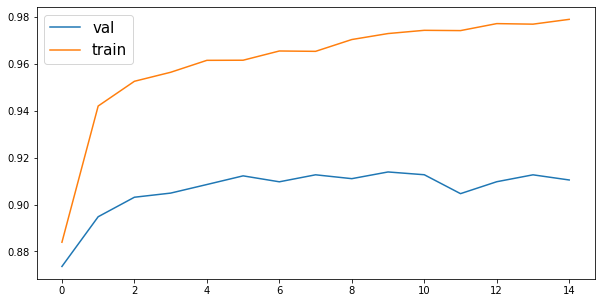

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_history_df['val_auc'], label='val')
plt.plot(train_history_df['auc'], label='train')
plt.legend(fontsize=15)

**Evaluating the model fit**

In [64]:
score = model.evaluate(x_valid,y_valid, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

250/250 [==============================] - 4s 18ms/step - loss: 0.2583 - accuracy: 0.8910 - auc: 0.9139
Test Score: 0.25825056433677673
Test Accuracy: 0.9138783812522888


**Test data toxic prediction**

In [65]:
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
test['content'] = test.apply(lambda x: clean_text(x['content']), axis=1)
test['content'] = test['content'].apply(lambda x: text_process(x))
x_test = fast_encode(test.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

output_distil = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

499/499 [==============================] - 20s 39ms/step


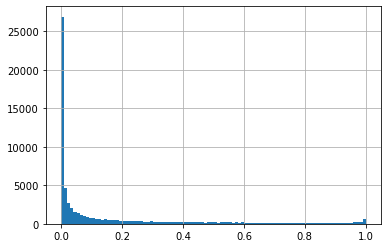

In [66]:
output_distil['toxic'] = model.predict(test_dataset, verbose=1)
output_distil['toxic'].hist(bins=100, log=False, alpha=1)
output_distil.to_csv('output_distilbert.csv', index=False)

In [67]:
output_distil

,id,toxic
0,0,0.057943
1,1,0.000119
2,2,0.351046
3,3,0.008145
4,4,0.000582
...,...,...
63807,63807,0.075397
63808,63808,0.001275
63809,63809,0.296671
63810,63810,0.065612


In [68]:
y_pred = model.predict(test_dataset, verbose=1)

499/499 [==============================] - 14s 29ms/step


In [69]:
y_pred

array([[5.7942778e-02],
       [1.1917949e-04],
       [3.5104576e-01],
       ...,
       [2.9667085e-01],
       [6.5612227e-02],
       [1.9518137e-03]], dtype=float32)

In [70]:
import random
spl = random.sample(range(len(y_pred)), 10)
for text, sentiment in zip(test.content[spl], y_pred[spl]):
    print(sentiment, text)

[0.21027511] , onay almadan, kimseye sormadan kafana göre resimleri çıkartıyorsun. Bilgi vermek amaçlı, tanıtmak amaçlı konmuş o fotoğraflar, istediğin gibi hareket ediyorsun. Ben geri alıp tartışma sayfasına git diyince senden değil den cevap alıyorum. Hayır yani, muhattabım senken bu kişinin olaya böyle gelmesi çok saçma değil mi? Neden karışıyorsun olaya Kudelski, avukat mısın sen? Bu ikinci kez avukat demem sana, her şeye karışmak gibi bir vazifen yok, toplumu kaosa sürüklüyorsun. Kibele kendisini ifade edip savunabilecek bir kullanıcı. Kür Şad mesaj
[0.00164601] Приводите авторитетные источники, и участники их рассмотрят. Только пожалуйста без очередного саенс-фрика , которого обидела официальная наука . Про Лысенко опять же уже сто раз сказано - человек примазался к власть имущим, поэтому особо активные критики были посланы куда подальше.
[0.6750128] y no estoy utilizando como foro pero tambien debes de tener en cuenta que es un estudio cientifico y que en otros paises (porque as